In [1]:
from poutyne import Model
from copy import deepcopy  # NEW
from scipy.stats import bernoulli

import numpy as np
import gym
import torch
import random


from collections import deque

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.__buffer_size = buffer_size
        # TODO : Add any needed attributes
        self.data = deque(maxlen=int(buffer_size))

    def store(self, element):
        """
        Stores an element. If the replay buffer is already full, deletes the oldest
        element to make space.
        """
        # TODO : Implement
        self.data.append(element)
        pass

    def get_batch(self, batch_size):
        """
        Returns a list of batch_size elements from the buffer.
        """
        buffer_list = list(self.data)
        return random.sample(buffer_list, batch_size)


class DQN(Model):
    def __init__(self, actions, *args, **kwargs):
        self.actions = actions
        super().__init__(*args, **kwargs)

    def get_action(self, state, epsilon):
        """
        Returns the selected action according to an epsilon-greedy policy.
        """
        # TODO: implement
        if bernoulli.rvs(epsilon):
            action = random.choice(self.actions)
        else:
            pred_r = self.predict(state)
            action = self.actions[np.argmax(pred_r)]
        return action


    def soft_update(self, other, tau):
        """
        Code for the soft update between a target network (self) and
        a source network (other).

        The weights are updated according to the rule in the assignment.
        """
        new_weights = {}

        own_weights = self.get_weight_copies()
        other_weights = other.get_weight_copies()

        for k in own_weights:
            new_weights[k] = (1 - tau) * own_weights[k] + tau * other_weights[k]

        self.set_weights(new_weights)


class NNModel(torch.nn.Module):
    """
    Neural Network with 3 hidden layers of hidden dimension 64.
    """

    def __init__(self, in_dim, out_dim, n_hidden_layers=3, hidden_dim=64):
        super().__init__()
        layers = [torch.nn.Linear(in_dim, hidden_dim), torch.nn.ReLU()]
        for _ in range(n_hidden_layers - 1):
            layers.extend([torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()])
        layers.append(torch.nn.Linear(hidden_dim, out_dim))

        self.fa = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.fa(x)


def format_batch(batch, target_network, gamma):
    """
    Input : 
        - batch, a list of n=batch_size elements from the replay buffer
        - target_network, the target network to compute the one-step lookahead target
        - gamma, the discount factor

    Returns :
        - states, a numpy array of size (batch_size, state_dim) containing the states in the batch
        - (actions, targets) : where actions and targets both
                      have the shape (batch_size, ). Actions are the 
                      selected actions according to the target network
                      and targets are the one-step lookahead targets.
    """
    # TODO: Implement

    states = np.array([x[0] for x in batch])
    actions_taken = np.array([x[1] for x in batch])
    rewards = np.array([x[2] for x in batch])
    next_states = np.array([x[3] for x in batch])
    terminal = np.array([x[4] for x in batch])

    next_qvals_predicted = target_network.predict(next_states)

    next_actions_vals_selected = np.max(next_qvals_predicted, axis=1)

    targets = rewards + gamma * next_actions_vals_selected * (1 - terminal)

    act_targ = (actions_taken.astype(np.int64), targets.astype(np.float32))

    return states, act_targ


def dqn_loss(y_pred, y_target):
    """
    Input :
        - y_pred, (batch_size, n_actions) Tensor outputted by the network
        - y_target = (actions, targets), where actions and targets both
                      have the shape (batch_size, ). Actions are the 
                      selected actions according to the target network
                      and targets are the one-step lookahead targets.

    Returns :
        - The DQN loss 
    """
    # C'est essentiellement le même travail que ce qui est fait dans update_theta
    # sauf (1) qu'on le fait en PyTorch et les fonctions n'ont pas le même nom
    # et (2) on ne calcule pas le gradient nous-mêmes, on fait juste donner la perte.
    # C'est PyTorch qui fait la descente de gradient pour nous.

    actions, targets = y_target
    q_pred = y_pred.gather(1, actions.unsqueeze(-1)).squeeze()

    return torch.nn.functional.mse_loss(q_pred, targets)

def set_random_seed(environment, seed):
    environment.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # NEW


def run_dqn(agent, seed=42):
    environment = gym.make("LunarLander-v2")
    set_random_seed(environment, seed=seed)

    env = gym.wrappers.Monitor(environment, "demo", force=True)

    done = False
    s = environment.reset().astype(np.float32)
    
    ##pour enregistrer les gains pour faire un graphique au début
    r_liste=[]
    
    while not done:
        env.render()
        q_vals = agent.predict(s)
        action = np.argmax(q_vals)
        next_s, r, done, _ = environment.step(action)

        s = next_s.astype(np.float32)
        
        ##Stock le gain
        r_liste.append(r)
        
    env.close()
    
    ###return les gains instantanés (les rewards pour chaque pas)
    return r_liste



In [2]:
# NEW : Added lr argument
def main(batch_size, gamma, buffer_size, seed, tau, training_interval, lr):
    environment = gym.make("LunarLander-v2")
    set_random_seed(environment, seed)

    actions = list(range(environment.action_space.n))
    model = NNModel(environment.observation_space.shape[0], environment.action_space.n)
    policy_net = DQN(
        actions,
        model,
        optimizer=torch.optim.Adam(model.parameters(), lr=lr),
        loss_function=dqn_loss,
    )
    # NEW: pass a deep copy of the model
    target_net = DQN(actions, deepcopy(model), optimizer="sgd", loss_function=dqn_loss,)
    replay_buffer = ReplayBuffer(buffer_size)

    training_done = False
    episodes_done = 0
    steps_done = 0
    epsilon = 1.0
    epsilon_decay = 0.9
    epsilon_min = 0.01
    n = 5 # Nombre d'épisodes de suite pour lequel la moyenne doit être >= 200 pour que l'apprentissage arrête 
    G_liste = [] #Pour emmagasiner le gain cumulé après chaque épisode
    loss_liste = [] #Pour emmagasiner la perte après chaque épisode

    while not training_done:
        s = environment.reset()
        episode_done = False
        G = 0
        while not episode_done:
            a = policy_net.get_action(s, epsilon)
            next_s, r, episode_done, _ = environment.step(a)
            replay_buffer.store((s, a, r, next_s, episode_done))
            s = next_s
            steps_done += 1
            G += r

            if steps_done % training_interval == 0:
                if len(replay_buffer.data) >= batch_size:
                    batch = replay_buffer.get_batch(batch_size)
                    x, y = format_batch(batch, target_net, gamma)
                    loss = policy_net.train_on_batch(x, y)
                    target_net.soft_update(policy_net, tau)

        # TODO: update epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        
        episodes_done += 1
        
        G_liste.append(G)
        loss_liste.append(loss)
        
        if episodes_done > n and np.mean(G_liste[-n:]) >= 200:
            training_done = True

        if (episodes_done) % 1 == 0:
            print(f"After {episodes_done} trajectoires, we have G_0 = {G:.2f}, {epsilon:4f}")

    return policy_net, G_liste, loss_liste, episodes_done

In [3]:
if __name__ == "__main__":
    """
    All hyperparameter values and overall code structure are
    only given as a baseline. 
    
    You can use them if they help  you, but feel free to implement
    from scratch the required algorithms if you wish !
    """
    batch_size = 32
    gamma = 0.99
    buffer_size = 1e5
    seed = 42
    tau = 1e-2
    training_interval = 4
    lr = 5e-4  # NEW lr as parameter

    # NEW : pass lr to main()
    dqn, Gains, Loss, n_episodes = main(batch_size, gamma, buffer_size, seed, tau, training_interval, lr)

C:\Users\Utilisateur\anaconda3\lib\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


After 1 trajectoires, we have G_0 = -162.58, 0.900000
After 2 trajectoires, we have G_0 = -433.71, 0.810000
After 3 trajectoires, we have G_0 = -339.72, 0.729000
After 4 trajectoires, we have G_0 = 24.13, 0.656100
After 5 trajectoires, we have G_0 = -205.06, 0.590490
After 6 trajectoires, we have G_0 = -485.17, 0.531441
After 7 trajectoires, we have G_0 = -255.23, 0.478297
After 8 trajectoires, we have G_0 = -321.50, 0.430467
After 9 trajectoires, we have G_0 = -457.85, 0.387420
After 10 trajectoires, we have G_0 = -337.80, 0.348678
After 11 trajectoires, we have G_0 = -260.25, 0.313811
After 12 trajectoires, we have G_0 = -85.85, 0.282430
After 13 trajectoires, we have G_0 = -129.04, 0.254187
After 14 trajectoires, we have G_0 = -451.04, 0.228768
After 15 trajectoires, we have G_0 = -504.29, 0.205891
After 16 trajectoires, we have G_0 = -416.43, 0.185302
After 17 trajectoires, we have G_0 = -267.28, 0.166772
After 18 trajectoires, we have G_0 = -131.96, 0.150095
After 19 trajectoires,

After 150 trajectoires, we have G_0 = -193.34, 0.010000
After 151 trajectoires, we have G_0 = -196.20, 0.010000
After 152 trajectoires, we have G_0 = -190.10, 0.010000
After 153 trajectoires, we have G_0 = -209.47, 0.010000
After 154 trajectoires, we have G_0 = -260.25, 0.010000
After 155 trajectoires, we have G_0 = -219.63, 0.010000
After 156 trajectoires, we have G_0 = -156.36, 0.010000
After 157 trajectoires, we have G_0 = -134.54, 0.010000
After 158 trajectoires, we have G_0 = -245.52, 0.010000
After 159 trajectoires, we have G_0 = -132.57, 0.010000
After 160 trajectoires, we have G_0 = -178.63, 0.010000
After 161 trajectoires, we have G_0 = -239.24, 0.010000
After 162 trajectoires, we have G_0 = -244.48, 0.010000
After 163 trajectoires, we have G_0 = -91.46, 0.010000
After 164 trajectoires, we have G_0 = -252.25, 0.010000
After 165 trajectoires, we have G_0 = -212.50, 0.010000
After 166 trajectoires, we have G_0 = -360.89, 0.010000
After 167 trajectoires, we have G_0 = -244.27, 0.

After 297 trajectoires, we have G_0 = -117.69, 0.010000
After 298 trajectoires, we have G_0 = -247.18, 0.010000
After 299 trajectoires, we have G_0 = -232.63, 0.010000
After 300 trajectoires, we have G_0 = -179.15, 0.010000
After 301 trajectoires, we have G_0 = -184.29, 0.010000
After 302 trajectoires, we have G_0 = -137.06, 0.010000
After 303 trajectoires, we have G_0 = -198.81, 0.010000
After 304 trajectoires, we have G_0 = -315.14, 0.010000
After 305 trajectoires, we have G_0 = -178.65, 0.010000
After 306 trajectoires, we have G_0 = -140.78, 0.010000
After 307 trajectoires, we have G_0 = -131.95, 0.010000
After 308 trajectoires, we have G_0 = -94.14, 0.010000
After 309 trajectoires, we have G_0 = -103.51, 0.010000
After 310 trajectoires, we have G_0 = -44.75, 0.010000
After 311 trajectoires, we have G_0 = -69.83, 0.010000
After 312 trajectoires, we have G_0 = -67.08, 0.010000
After 313 trajectoires, we have G_0 = -19.46, 0.010000
After 314 trajectoires, we have G_0 = -122.77, 0.0100

After 446 trajectoires, we have G_0 = -48.73, 0.010000
After 447 trajectoires, we have G_0 = -43.32, 0.010000
After 448 trajectoires, we have G_0 = 0.16, 0.010000
After 449 trajectoires, we have G_0 = -22.17, 0.010000
After 450 trajectoires, we have G_0 = -37.89, 0.010000
After 451 trajectoires, we have G_0 = -16.93, 0.010000
After 452 trajectoires, we have G_0 = -11.53, 0.010000
After 453 trajectoires, we have G_0 = -41.72, 0.010000
After 454 trajectoires, we have G_0 = -14.96, 0.010000
After 455 trajectoires, we have G_0 = -29.07, 0.010000
After 456 trajectoires, we have G_0 = -40.77, 0.010000
After 457 trajectoires, we have G_0 = -49.73, 0.010000
After 458 trajectoires, we have G_0 = -27.24, 0.010000
After 459 trajectoires, we have G_0 = -39.64, 0.010000
After 460 trajectoires, we have G_0 = 16.23, 0.010000
After 461 trajectoires, we have G_0 = -34.48, 0.010000
After 462 trajectoires, we have G_0 = 23.45, 0.010000
After 463 trajectoires, we have G_0 = 29.03, 0.010000
After 464 traje

After 597 trajectoires, we have G_0 = 196.03, 0.010000
After 598 trajectoires, we have G_0 = 195.46, 0.010000
After 599 trajectoires, we have G_0 = -47.03, 0.010000
After 600 trajectoires, we have G_0 = -7.67, 0.010000
After 601 trajectoires, we have G_0 = -302.96, 0.010000
After 602 trajectoires, we have G_0 = 111.89, 0.010000
After 603 trajectoires, we have G_0 = 146.55, 0.010000
After 604 trajectoires, we have G_0 = 23.07, 0.010000
After 605 trajectoires, we have G_0 = 232.13, 0.010000
After 606 trajectoires, we have G_0 = 138.15, 0.010000
After 607 trajectoires, we have G_0 = -14.33, 0.010000
After 608 trajectoires, we have G_0 = 93.95, 0.010000
After 609 trajectoires, we have G_0 = -58.55, 0.010000
After 610 trajectoires, we have G_0 = 239.42, 0.010000
After 611 trajectoires, we have G_0 = 241.98, 0.010000
After 612 trajectoires, we have G_0 = 108.78, 0.010000
After 613 trajectoires, we have G_0 = 201.09, 0.010000
After 614 trajectoires, we have G_0 = -142.45, 0.010000
After 615 t

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

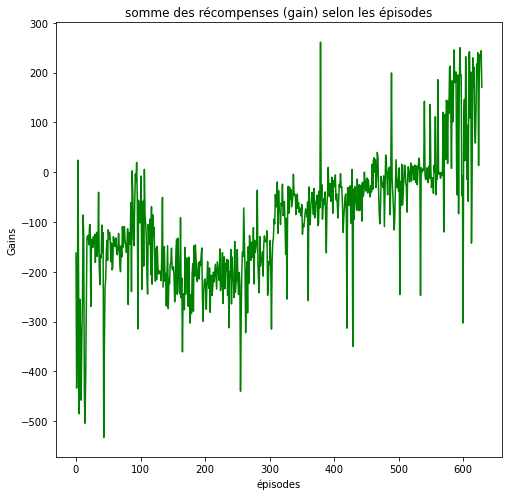

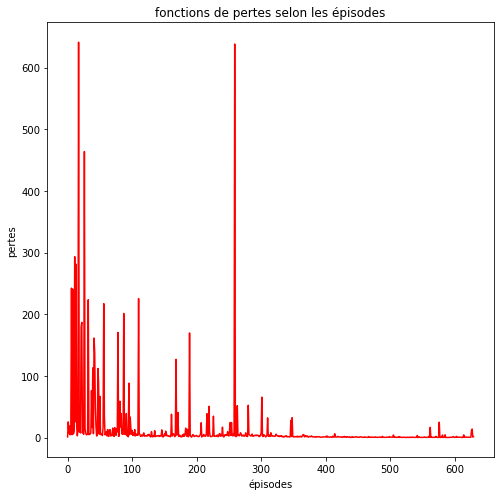

In [5]:
plt.plot(range(n_episodes), Gains, color='green')
plt.xlabel('épisodes')
plt.ylabel('Gains')
plt.title('somme des récompenses (gain) selon les épisodes')
plt.savefig("gains.pdf", bbox_inches='tight')
plt.show()
plt.plot(range(n_episodes), Loss, color='red')
plt.xlabel('épisodes')
plt.ylabel('pertes')
plt.title('fonctions de pertes selon les épisodes')
plt.savefig("pertes.pdf", bbox_inches='tight')
plt.show()

In [23]:
r_liste=run_dqn(dqn,seed=12)

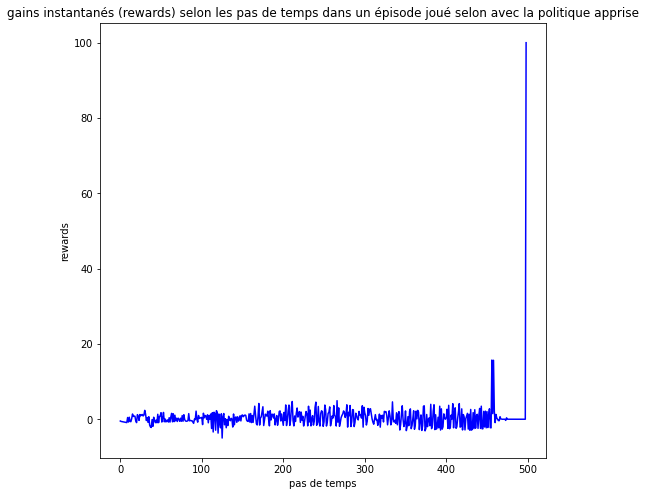

In [24]:
plt.plot(range(len(r_liste)), r_liste, color='blue')
plt.xlabel('pas de temps')
plt.ylabel('rewards')
plt.title('gains instantanés (rewards) selon les pas de temps dans un épisode joué selon avec la politique apprise')
plt.savefig("gain_par_pas.pdf", bbox_inches='tight')
plt.show()

In [18]:
run_dqn(dqn,seed=57)

[1.1693315290988562,
 1.3405432147075953,
 1.5815150471414665,
 0.6942910886965876,
 0.6647195858266457,
 0.6295267144618037,
 0.588763557077499,
 0.5423627405199909,
 0.49057287553284823,
 0.4336824756340434,
 0.37206440358042414,
 0.3063240231520865,
 0.23712024551775812,
 0.16522004988530625,
 0.09153027192627405,
 0.01697659533112983,
 -0.057463685963853095,
 -0.1308369865197676,
 -0.20219424248139717,
 -0.2706795605083414,
 -0.335598552978837,
 -0.3962341357855337,
 1.6140591905794224,
 -0.43692704706145946,
 0.15888872525804915,
 -0.5114076420680931,
 1.606604404702108,
 -0.5112952320108661,
 -1.09811665620079,
 -0.9788640171932912,
 1.3824711901660691,
 0.38308832187247505,
 -0.23483249848765125,
 -0.33165069967185445,
 -0.3899814904912091,
 2.17224659668359,
 -0.4705795972622582,
 0.4501070439072919,
 -0.41990693987099803,
 -0.6593335515083141,
 0.639906401005818,
 -0.8167874978505438,
 1.3328526241190672,
 -1.293187966779118,
 -0.7309819191943063,
 -0.07516276197115984,
 -0.94

In [16]:
run_dqn(dqn,seed=99)

[-1.435112821492878,
 -2.833899488904193,
 -2.4235839239494226,
 -2.5761995757817715,
 -2.6127901644149745,
 -2.6032547235062964,
 -0.10143689196103195,
 2.274278342271498,
 -2.6111581500973955,
 -2.5834849680802847,
 1.5238192835117388,
 2.3024779642160356,
 -2.7269710149327864,
 1.2786796822029032,
 -2.713315328853838,
 2.236339204120367,
 -0.7387769958881905,
 -2.717191237450237,
 2.616329173277859,
 -2.801279102306381,
 1.719119396209902,
 1.84425522900828,
 -2.95120531761566,
 1.7121062628729475,
 -2.760966809179932,
 1.5219459226900767,
 -2.7030747231991654,
 2.5550569256901783,
 -2.806501826413921,
 0.36947211404863084,
 -2.626954162339672,
 0.28509065300015096,
 -2.3695969515918307,
 -1.7597071111487697,
 -0.4451755985326031,
 1.934254285723864,
 -2.023850842994335,
 -2.04314089072372,
 -0.1353968261637874,
 1.4845822284299686,
 -1.8190149476924091,
 -1.8483904740717492,
 3.3128324301446073,
 -1.374502702565336,
 0.8466714588660238,
 -1.5746791560634108,
 -1.607799287015979,
 2